
## Открытый курс по машинному обучению. Сессия № 2

Автор материала: Юрий Исаков и Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Тема 4. Линейные модели классификации и регрессии
## <center>  Практика. Идентификация пользователя с помощью логистической регрессии

Тут мы воспроизведем парочку бенчмарков нашего соревнования и вдохновимся побить третий бенчмарк, а также остальных участников. Веб-формы для отправки ответов тут не будет, ориентир – [leaderboard](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/leaderboard) соревнования.

In [1]:
import pickle

import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score, StratifiedKFold

import warnings
warnings.filterwarnings('ignore')


%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt

### 1. Загрузка и преобразование данных
Зарегистрируйтесь на [Kaggle](www.kaggle.com), если вы не сделали этого раньше, зайдите на [страницу](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) соревнования и скачайте данные. Первым делом загрузим обучающую и тестовую выборки и посмотрим на данные.

In [5]:
times = ["time%s" % i for i in range(1, 11)]
train_df = pd.read_csv("data/train_sessions.csv", index_col="session_id", parse_dates=times)
test_df = pd.read_csv("data/test_sessions.csv", index_col="session_id", parse_dates=times)

# отсортируем данные по времени
train_df = train_df.sort_values(by="time1")

# посмотрим на заголовок обучающей выборки
train_df.head(2)

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0


В обучающей выборке содержатся следующие признаки:
    - site1 – индекс первого посещенного сайта в сессии
    - time1 – время посещения первого сайта в сессии
    - ...
    - site10 – индекс 10-го посещенного сайта в сессии
    - time10 – время посещения 10-го сайта в сессии
    - target – целевая переменная, 1 для сессий Элис, 0 для сессий других пользователей
    
Сессии пользователей выделены таким образом, что они не могут быть длиннее получаса или 10 сайтов. То есть сессия считается оконченной либо когда пользователь посетил 10 сайтов подряд либо когда сессия заняла по времени более 30 минут.

В таблице встречаются пропущенные значения, это значит, что сессия состоит менее, чем из 10 сайтов. Заменим пропущенные значения нулями и приведем признаки к целому типу. Также загрузим словарь сайтов и посмотрим, как он выглядит:

In [7]:
# приведем колонки site1, ..., site10 к целочисленному формату и заменим пропуски нулями
sites = ["site%s" % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype("int")
test_df[sites] = test_df[sites].fillna(0).astype("int")

# загрузим словарик сайтов
with open(r"data/site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)

# датафрейм словарика сайтов
sites_dict_df = pd.DataFrame(
    list(site_dict.keys()), index=list(site_dict.values()), columns=["site"]
)
print(u"всего сайтов:", sites_dict_df.shape[0])
sites_dict_df.head()

всего сайтов: 48371


,site
25075,www.abmecatronique.com
13997,groups.live.com
42436,majeureliguefootball.wordpress.com
30911,cdt46.media.tourinsoft.eu
8104,www.hdwallpapers.eu


### EDA

In [49]:
# The most popular sites
top_sites = pd.Series(train_df[sites].values.flatten()) \
                     .value_counts().sort_values(ascending=False).head(10)
sites_dict_df.loc[top_sites.drop(0).index]

,site
21,www.google.fr
23,www.google.com
782,annotathon.org
22,apis.google.com
29,www.facebook.com
167,www.bing.com
780,blast.ncbi.nlm.nih.gov
778,www.ncbi.nlm.nih.gov
52,clients1.google.com


#### The most popular sites for Alice

In [55]:
top_sites_Alice = pd.Series(train_df.loc[train_df.target==1, sites].values.flatten()) \
                     .value_counts().sort_values(ascending=False).head(10)
sites_dict_df.loc[top_sites_Alice.index]

,site
77,i1.ytimg.com
80,s.youtube.com
76,www.youtube.com
29,www.facebook.com
21,www.google.fr
81,r4---sn-gxo5uxg-jqbe.googlevideo.com
22,apis.google.com
879,r1---sn-gxo5uxg-jqbe.googlevideo.com
75,s.ytimg.com
82,r2---sn-gxo5uxg-jqbe.googlevideo.com


#### Looking timestapms

In [79]:
time_df = pd.DataFrame(index=train_df.index)
time_df['target'] = train_df['target']
time_df['min'] = train_df[times].min(axis=1)
time_df['max'] = train_df[times].max(axis=1)
time_df['seconds'] = (time_df['max'] - time_df['min']).dt.seconds
time_df

,target,min,max,seconds
session_id,,,,
21669,0,2013-01-12 08:05:57,2013-01-12 08:05:57,0
54843,0,2013-01-12 08:37:23,2013-01-12 09:07:09,1786
77292,0,2013-01-12 08:50:13,2013-01-12 08:50:17,4
114021,0,2013-01-12 08:50:17,2013-01-12 08:50:20,3
146670,0,2013-01-12 08:50:20,2013-01-12 08:50:22,2
...,...,...,...,...
12224,0,2014-04-30 23:33:48,2014-04-30 23:34:00,12
164438,0,2014-04-30 23:34:15,2014-04-30 23:37:13,178
12221,0,2014-04-30 23:38:08,2014-04-30 23:38:36,28


In [127]:
time_df['target'].value_counts(normalize=True) * 100

0    99.094104
1     0.905896
Name: target, dtype: float64

In [128]:
def approximately_same(x, y):
    return abs(x-y) / max(x, y) <= 0.05

In [134]:
# Alice session mean
alice_mean = time_df[time_df['target'] == 1]['seconds'].mean()
not_alice_mean = time_df[time_df['target'] == 0]['seconds'].mean()
print(f'Alice mean session: {alice_mean}')
print(f'Not Alice mean session: {not_alice_mean}')

# Max time session is appoximately the same
max_Alice_session = time_df[time_df['target'] == 1]['seconds'].max()
max_not_Alice_session = time_df[time_df['target'] == 0]['seconds'].max()
print(f'Alice max ~ others max: {approximately_same(max_Alice_session, max_not_Alice_session)}')

alice_std = time_df[time_df['target'] == 1]['seconds'].std()
not_alice_std = time_df[time_df['target'] == 0]['seconds'].std()
approximately_same(alice_std, not_alice_std)
print(f'Alice std ~ others std: {approximately_same(alice_std, not_alice_std)}')

Alice mean session: 52.29647366129734
Not Alice mean session: 139.28237232552215
Alice max ~ others max: True
Alice std ~ others std: False


0.2411841532433609

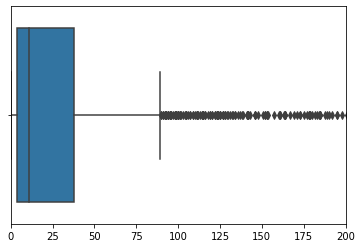

In [135]:
sns.boxplot(time_df[time_df['target'] == 1]['seconds'].values)
plt.xlim([0, 200])
(time_df[time_df['target'] == 1]['seconds'] >= 40).sum() / time_df[time_df['target'] == 1].shape[0]

In [136]:
time_df.groupby('target')['seconds'].describe()

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0,251264.0,139.282372,296.653518,0.0,7.0,28.0,114.0,1800.0
1,2297.0,52.296474,153.309014,0.0,4.0,11.0,38.0,1763.0


In [189]:
# Dataframe for new features
full_new_feat = pd.DataFrame(index=full_df.index)

# Add start_month feature
full_new_feat["start_month"] = (
    full_df["time1"].apply(lambda ts: 100 * ts.year + ts.month).astype("float64")
)

start_month
201301.0      0
201302.0     61
201303.0      0
201304.0     38
201305.0      0
201306.0      0
201307.0      0
201308.0      0
201309.0    377
201310.0      0
201311.0    446
201312.0    134
201401.0    129
201402.0    410
201403.0    400
201404.0    302
Name: target, dtype: int64


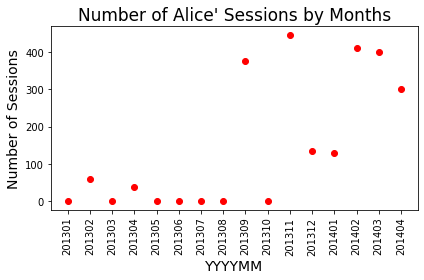

In [190]:
# Answer

# Compute number of Alice's sessions by months
tmp = full_new_feat.loc[:idx_split, "start_month"].to_frame()
tmp["target"] = y_train
stm_vs_target = tmp.groupby("start_month")["target"].sum()

# Print the table
print(stm_vs_target)

# Plot the graph
x_axis = stm_vs_target.index.astype("int").astype("str")
y_axis = stm_vs_target.values
plt.plot(x_axis, y_axis, "ro")
plt.xticks(x_axis, x_axis, rotation="vertical")
plt.xlabel("YYYYMM", fontsize=14)
plt.ylabel("Number of Sessions", fontsize=14)
plt.title(u"Number of Alice' Sessions by Months", y=1.0, fontsize=17)
plt.tight_layout();

### Prepare Data

Выделим целевую переменную и объединим выборки, чтобы вместе привести их к разреженному формату.

In [137]:
# наша целевая переменная
y_train = train_df["target"]

# объединенная таблица исходных данных
full_df = pd.concat([train_df.drop("target", axis=1), test_df])

# индекс, по которому будем отделять обучающую выборку от тестовой
idx_split = train_df.shape[0]

Для самой первой модели будем использовать только посещенные сайты в сессии (но не будем обращать внимание на временные признаки). За таким выбором данных для модели стоит такая идея:  *у Элис есть свои излюбленные сайты, и чем чаще вы видим эти сайты в сессии, тем выше вероятность, что это сессия Элис и наоборот.*

Подготовим данные, из всей таблицы выберем только признаки `site1, site2, ... , site10`. Напомним, что пропущенные значения заменены нулем. Вот как выглядят первые строки таблицы:

In [138]:
# табличка с индексами посещенных сайтов в сессии
full_sites = full_df[sites]
full_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0
54843,56,55,56,55,0,0,0,0,0,0
77292,946,946,951,946,946,945,948,784,949,946
114021,945,948,949,948,945,946,947,945,946,946
146670,947,950,948,947,950,952,946,951,946,947


In [18]:
full_sites.values.flatten()

array([  56,   55,    0, ..., 1098, 1098, 1098])

Сессии представляют собой последовательность индексов сайтов и данные в таком виде неудобны для линейных методов. В соответствии с нашей гипотезой (у Элис есть излюбленные сайты) надо преобразовать эту таблицу таким образом, чтобы каждому возможному сайту соответствовал свой отдельный признак (колонка), а его значение равнялось бы количеству посещений этого сайта в сессии. Это делается в две строчки:

In [141]:
from scipy.sparse import csr_matrix

In [142]:
csr_matrix?

In [143]:
# последовательность с индексами
sites_flatten = full_sites.values.flatten()

# искомая матрица
full_sites_sparse = csr_matrix(
    (
        [1] * sites_flatten.shape[0],
        sites_flatten,
        range(0, sites_flatten.shape[0] + 10, 10),
    )
)[:, 1:]
full_sites_sparse.shape

(336358, 48371)

In [35]:
X_train_sparse = full_sites_sparse[:idx_split]
X_test_sparse = full_sites_sparse[idx_split:]

In [36]:
X_train_sparse.shape, y_train.shape

((253561, 48371), (253561,))

Еще один плюс использования разреженных матриц в том, что для них имеются специальные реализации как матричных операций, так и алгоритмов машинного обучения, что подчас позволяет ощутимо ускорить операции за счет особенностей структуры данных. Это касается и логистической регрессии. Вот теперь у нас все готово для построения нашей первой модели.

### 2. Построение первой модели

Итак, у нас есть алгоритм и данные для него, построим нашу первую модель, воспользовавшись релизацией [логистической регрессии](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) из пакета `sklearn` с параметрами по умолчанию. Первые 90% данных будем использовать для обучения (обучающая выборка отсортирована по времени), а оставшиеся 10% для проверки качества (validation). 

**Напишите простую функцию, которая будет возвращать качество модели на отложенной выборке, и обучите наш первый классификатор**.

In [43]:
def get_auc_lr_valid(X, y, C=1.0, ratio=0.9, seed=17):
    """
    X, y – выборка
    ratio – в каком отношении поделить выборку
    C, seed – коэф-т регуляризации и random_state 
              логистической регрессии
    """

    train_len = int(X.shape[0] * ratio)
    X_train = X[:train_len]
    y_train = y[:train_len]
    X_valid = X[train_len:]
    y_valid = y[train_len:]
    
    logit = LogisticRegression(C=C, random_state=seed, n_jobs=-1)
    logit.fit(X_train, y_train)
    pred_valid = logit.predict_proba(X_valid)[:, 1]
    return roc_auc_score(y_valid, pred_valid)

**Посмотрите, какой получился ROC AUC на отложенной выборке.**

In [44]:
%%time
get_auc_lr_valid(X_train_sparse, y_train)

CPU times: user 100 ms, sys: 44.4 ms, total: 145 ms
Wall time: 2.5 s


0.9197952555886044

Будем считать эту модель нашей первой отправной точкой (baseline). Для построения модели для прогноза на тестовой выборке **необходимо обучить модель заново уже на всей обучающей выборке** (пока наша модель обучалась лишь на части данных), что повысит ее обобщающую способность:

In [141]:
# функция для записи прогнозов в файл
def write_to_submission_file(
    predicted_labels, out_file, target="target", index_label="session_id"
):
    predicted_df = pd.DataFrame(
        predicted_labels,
        index=np.arange(1, predicted_labels.shape[0] + 1),
        columns=[target],
    )
    predicted_df.to_csv(out_file, index_label=index_label)

**Обучите модель на всей выборке, сделайте прогноз для тестовой выборки и сделайте посылку в соревновании**.

In [48]:
logit = LogisticRegression(C=1, random_state=17, n_jobs=-1)
logit.fit(X_train_sparse, y_train)
test_pred = logit.predict_proba(X_test_sparse)[:, 1]

In [146]:
write_to_submission_file(test_pred, 'logit.csv')

/Users/kremenevskiy/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Если вы выполните эти действия и загрузите ответ на [странице](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) соревнования, то воспроизведете первый бенчмарк "Logit".

### 3. Улучшение модели, построение новых признаков

Создайте такой признак, который будет представлять собой число вида ГГГГММ от той даты, когда проходила сессия, например 201407 -- 2014 год и 7 месяц. Таким образом, мы будем учитывать помесячный [линейный тренд](http://people.duke.edu/~rnau/411trend.htm) за весь период предоставленных данных.

In [57]:
new_feat_train = pd.DataFrame(index=train_df.index)
new_feat_test = pd.DataFrame(index=test_df.index)

In [59]:
new_feat_train['year_month'] = train_df['time1'].apply(lambda x: int(x.year * 100 + x.month))
new_feat_test['year_month'] = test_df['time1'].apply(lambda x: int(x.year * 100 + x.month))

Добавьте новый признак, предварительно отмасштабировав его с помощью `StandardScaler`, и снова посчитайте ROC AUC на отложенной выборке.

In [63]:
scaler = StandardScaler()
scaler.fit(new_feat_train.values.reshape(-1, 1))

new_feat_train['year_month_scaled'] = scaler.transform(new_feat_train['year_month'].values.reshape(-1, 1))
new_feat_test['year_month_scaled'] = scaler.transform(new_feat_test['year_month'].values.reshape(-1, 1))

In [65]:
new_feat_train.head()

,year_month,year_month_scaled
session_id,,
21669,201301,-1.744405
54843,201301,-1.744405
77292,201301,-1.744405
114021,201301,-1.744405
146670,201301,-1.744405


In [67]:
X_train_sparse_new = csr_matrix(hstack([X_train_sparse, new_feat_train['year_month_scaled'].values.reshape(-1, 1)]))

In [78]:
X_test_sparse_new = csr_matrix(hstack([X_test_sparse, new_feat_test['year_month_scaled'].values.reshape(-1, 1)]))

In [145]:
%%time
get_auc_lr_valid(X_train_sparse_new, y_train)

CPU times: user 65.9 ms, sys: 79 ms, total: 145 ms
Wall time: 5.06 s


0.9198902054055882

**Добавьте два новых признака: start_hour и morning.**

Признак `start_hour` – это час в который началась сессия (от 0 до 23), а бинарный признак `morning` равен 1, если сессия началась утром и 0, если сессия началась позже (будем считать, что утро это если `start_hour равен` 11 или меньше).

**Посчитйте ROC AUC на отложенной выборке для выборки с:**
- сайтами, `start_month` и `start_hour`
- сайтами, `start_month` и `morning`
- сайтами, `start_month`, `start_hour` и `morning`

In [95]:
new_feat_train['start_hour'] = train_df['time1'].apply(lambda x: x.hour)
new_feat_test['start_hour'] = test_df['time1'].apply(lambda x: x.hour)

new_feat_train['is_morning'] = (new_feat_train['start_hour'] <= 11).astype('int')
new_feat_test['is_morning'] = (new_feat_test['start_hour'] <= 11).astype('int')

new_feat_train['start_month'] = train_df['time1'].apply(lambda x: x.month)
new_feat_test['start_month'] = test_df['time1'].apply(lambda x: x.month)

In [96]:
scaler = StandardScaler()
scaler.fit(new_feat_train[['start_hour', 'is_morning', 'start_month']])

new_feat_train[['start_hour_scaled', 'is_morning_scaled', 'start_month_scaled']] = scaler.transform(new_feat_train[['start_hour', 'is_morning', 'start_month']])
new_feat_test[['start_hour_scaled', 'is_morning_scaled', 'start_month_scaled']] = scaler.transform(new_feat_test[['start_hour', 'is_morning', 'start_month']])

In [101]:
# start_month и start_hour
X_train_sparse_check =  csr_matrix(hstack([X_train_sparse_new, new_feat_train[['start_hour_scaled', 'start_month_scaled']]]))
get_auc_lr_valid(X_train_sparse_check, y_train)

0.957577282207159

In [102]:
# start_month и morning
X_train_sparse_check =  csr_matrix(hstack([X_train_sparse_new, new_feat_train[['is_morning_scaled', 'start_month_scaled']]]))
get_auc_lr_valid(X_train_sparse_check, y_train)

0.9480045594026585

In [103]:
# start_hour и morning
X_train_sparse_check =  csr_matrix(hstack([X_train_sparse_new, new_feat_train[['is_morning_scaled', 'start_hour_scaled']]]))
get_auc_lr_valid(X_train_sparse_check, y_train)

0.9586546380796769

In [104]:
X_train_sparse_featured = csr_matrix(hstack([X_train_sparse_new, new_feat_train[['start_hour_scaled', 'is_morning_scaled', 'start_month_scaled']]]))
X_test_sparse_featured = csr_matrix(hstack([X_test_sparse_new, new_feat_test[['start_hour_scaled', 'is_morning_scaled', 'start_month_scaled']]]))

In [105]:
%%time
get_auc_lr_valid(X_train_sparse_featured, y_train)

CPU times: user 56.8 ms, sys: 38.3 ms, total: 95.1 ms
Wall time: 2.81 s


0.9586360707863716

In [86]:
logit = LogisticRegression(C=1, random_state=17, n_jobs=-1)
logit.fit(X_train_sparse_featured, y_train)
test_pred = logit.predict_proba(X_test_sparse_featured)[:, 1]

In [87]:
write_to_submission_file(test_pred, 'logit_with_features.csv')

### 4. Подбор коэффицициента регуляризации

Итак, мы ввели признаки, которые улучшают качество нашей модели по сравнению с первым бейслайном. Можем ли мы добиться большего значения метрики? После того, как мы сформировали обучающую и тестовую выборки, почти всегда имеет смысл подобрать оптимальные гиперпараметры -- характеристики модели, которые не изменяются во время обучения. Например, на 3 неделе вы проходили решающие деревья, глубина дерева это гиперпараметр, а признак, по которому происходит ветвление и его значение -- нет. В используемой нами логистической регрессии веса каждого признака изменяются и во время обучения находится их оптимальные значения, а коэффициент регуляризации остается постоянным. Это тот гиперпараметр, который мы сейчас будем оптимизировать.

Посчитайте качество на отложенной выборке с коэффициентом регуляризации, который по умолчанию `C=1`:

In [88]:
get_auc_lr_valid(X_train_sparse_featured, y_train, C=1)

0.9586546380796769

Постараемся побить этот результат за счет оптимизации коэффициента регуляризации. Возьмем набор возможных значений C и для каждого из них посчитаем значение метрики на отложенной выборке.

Найдите `C` из `np.logspace(-3, 1, 10)`, при котором ROC AUC на отложенной выборке максимален. 

In [89]:
C_values = np.logspace(-3, 1, 10)
C_vals = dict()
for c in C_values:
    score = get_auc_lr_valid(X_train_sparse_featured, y_train, C=c)
    C_vals[c] = score

In [90]:
max(C_vals.items(), key = lambda k : k[1])

(0.1668100537200059, 0.9607205891054973)

Наконец, обучите модель с найденным оптимальным значением коэффициента регуляризации и с построенными признаками `start_hour`, `start_month` и `morning`. Если вы все сделали правильно и загрузите это решение, то повторите второй бенчмарк соревнования.

In [106]:
logit = LogisticRegression(C=0.17, random_state=17, n_jobs=-1)
logit.fit(X_train_sparse_featured, y_train)
test_pred = logit.predict_proba(X_test_sparse_featured)[:, 1]

In [144]:
write_to_submission_file(test_pred, 'logit_with_features_regularized.csv')

### Другой подход Count Vectorizer

In [43]:
train_df[sites].to_csv('train_sites.txt', sep=' ', index=None, header=None)
test_df[sites].to_csv('test_sites.txt', sep=' ', index=None, header=None)
y = train_df['target']

In [44]:
vectorizer = CountVectorizer()
with open('train_sites.txt') as train_txt:
    train = vectorizer.fit_transform(train_txt)
with open('test_sites.txt') as test_txt:
    test = vectorizer.transform(test_txt)

In [46]:
logit = LogisticRegression(random_state=19)
scores = cross_val_score(logit, train, y, cv=5, scoring='roc_auc', n_jobs=-1)

In [47]:
print(scores.mean())
scores

0.8859549190229193


array([0.91412172, 0.83253933, 0.87702207, 0.89228333, 0.91380815])

### Adding 4 good features

In [148]:
def add_features(time1_Series, X, scaler, is_train=True):
    hour = time1_Series.apply(lambda x: x.hour)
    is_morning = ((hour >=7) & (hour <= 11)).astype(int)
    is_day = ((hour >=12) & (hour <= 18)).astype(int)
    is_evening = ((hour >=19) & (hour <= 23)).astype(int)
    is_night = ((hour >= 0) & (hour <=6)).astype(int)
    features = pd.DataFrame({'is_morning': is_morning, 'is_day': is_day, 'is_evening': is_evening, 'is_night': is_night})
    if is_train:
        features = scaler.fit_transform(features)
    else:
        features = scaler.transform(features)
    return hstack([X, features])

In [149]:
scaler = StandardScaler()
train_features_4 = add_features(train_df['time1'], train, scaler=scaler)
test_features_4 = add_features(test_df['time1'], test, scaler=scaler, is_train=False)

In [150]:
logit = LogisticRegression(random_state=19)
scores = cross_val_score(logit, train_features_4, y, cv=5, scoring='roc_auc', n_jobs=-1)

In [151]:
print(scores.mean())
scores

0.9311469193976434


array([0.92492484, 0.90717193, 0.93226761, 0.94376193, 0.94760829])

### Add regularization

In [154]:
%%time
c_vals = np.logspace(-2, 2, 40)
skv = StratifiedKFold(n_splits=10, shuffle=True, random_state=19)
logit_cv = LogisticRegressionCV(Cs=c_vals, n_jobs=-1, random_state=19, cv=skv, scoring='roc_auc')
logit_cv.fit(train_features_4, y)

/Users/kremenevskiy/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kremenevskiy/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

/Users/kremenevskiy/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kremenevskiy/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

/Users/kremenevskiy/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kremenevskiy/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

/Users/kremenevskiy/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kremenevskiy/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

/Users/kremenevskiy/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kremenevskiy/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

/Users/kremenevskiy/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kremenevskiy/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

/Users/kremenevskiy/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kremenevskiy/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

/Users/kremenevskiy/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kremenevskiy/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

/Users/kremenevskiy/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kremenevskiy/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

CPU times: user 6.9 s, sys: 1.58 s, total: 8.48 s
Wall time: 5min 13s


/Users/kremenevskiy/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegressionCV(Cs=array([1.00000000e-02, 1.26638017e-02, 1.60371874e-02, 2.03091762e-02,
       2.57191381e-02, 3.25702066e-02, 4.12462638e-02, 5.22334507e-02,
       6.61474064e-02, 8.37677640e-02, 1.06081836e-01, 1.34339933e-01,
       1.70125428e-01, 2.15443469e-01, 2.72833338e-01, 3.45510729e-01,
       4.37547938e-01, 5.54102033e-01, 7.01703829e-01, 8.88623816e-01,
       1.12533558e+00, 1.42...00,
       2.89426612e+00, 3.66524124e+00, 4.64158883e+00, 5.87801607e+00,
       7.44380301e+00, 9.42668455e+00, 1.19377664e+01, 1.51177507e+01,
       1.91448198e+01, 2.42446202e+01, 3.07029063e+01, 3.88815518e+01,
       4.92388263e+01, 6.23550734e+01, 7.89652287e+01, 1.00000000e+02]),
                     cv=StratifiedKFold(n_splits=10, random_state=19, shuffle=True),
                     n_jobs=-1, random_state=19, scoring='roc_auc')

In [156]:
best_c = logit_cv.C_

### Fit on all data

In [158]:
best_logit = LogisticRegression(random_state=19, C=best_c[0])
best_logit.fit(train_features_4, y)
pred = best_logit.predict_proba(test_features_4)[:, 1]
write_to_submission_file(pred, 'with_reg.csv')

/Users/kremenevskiy/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
